## 分析題目

    1. 動作和戰爭片的關聯性
    
       問題情境：
       我特愛看動作電影，如Mission: Impossible。但朋友看戰爭片時都會約我，
       或許他們認為戰爭片包含了動作的元素，而我又討厭看戰爭片，
       其通常較寫實，頗不爽快(唯獨Enemy at the Gates不算，它棒透了)
       機會難得，我想看看動作片和戰爭片在評價的關聯性。
       
       分析結論：
       兩者的皮爾森係數很低，表示動作和戰爭片兩種電影關聯性很小，太好了，下回可以拿這個結果勇敢拒絕邀約。
       
       
    2. 電影類型影響評價
    
    　 問題情境：
       常看到網路上"Marvel英雄題材嘛，大家都愛"、"硬科幻、恐怖電影是小眾市場"這類的言論。
       我想分析電影的類型是否會影響該電影的評價，並利用機器學習做出分析結果。
       
       分析結論：
       先試試線性回歸，因為它可以很快地給出結果。   
       結果非常不理想，R Squared甚至為負數，  
       瞎猜的機率或許還比較高，這表示數據間沒什麼線性關係。
       
       再試試其他複合式模型(快速套用其他模型是Python的強項)，   
       R Squared提升了，但是狀況依舊。  
       看來電影公司可以大膽拍攝不同類型的電影，不用擔心小不小眾的問題了。
       
       
    3. 電影評價與票房
    
       問題情境：
       電影的評價代表觀眾是否喜歡這部電影，對片商而言更重要的是，觀眾是否會掏錢進戲院觀影，
       再二刷三刷四刷甚至到ptt上洗版推坑。因此我想要知道電影的評價和票房的關係。
       這題裡，Movielens沒有票房的資料，爬蟲到IMDB上獲取。Movielens的評價範圍(0~5)較窄，
       故評價的部分也一起改用IMDB的(0~10)，在資料視覺化方面會更為明顯。
       
       分析結論：  
       觀察散佈圖，即使在低成本的電影區間，兩種特徵仍無明顯的正相關，看來電影評價與票房不一定成正比。

## ● Data Exploration

In [9]:
import pandas as pd

In [10]:
movies = pd.read_csv('ml-20m/movies.csv', sep=',')
tags = pd.read_csv('ml-20m/tags.csv', sep=',')
ratings = pd.read_csv('ml-20m/ratings.csv', sep=',')
links = pd.read_csv('ml-20m/links.csv', sep=',')

In [11]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [13]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [14]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [15]:
del tags['timestamp']
del ratings['timestamp']

In [16]:
tags.head()

,userId,movieId,tag
0,18,4141,Mark Waters
1,65,208,dark hero
2,65,353,dark hero
3,65,521,noir thriller
4,65,592,dark hero


In [17]:
tags.shape

(465564, 3)

In [18]:
# I dont need tags which are null.
tags.isnull().any()

userId     False
movieId    False
tag         True
dtype: bool

In [19]:
# Drop null.
tags = tags.dropna()

In [20]:
#Confirm there's no null value.
tags.isnull().any()

userId     False
movieId    False
tag        False
dtype: bool

In [21]:
tags.shape

(465548, 3)

In [22]:
ratings['rating'].describe()

count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [23]:
movies.shape

(27278, 3)

In [24]:
# No null
movies.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

In [25]:
ratings.shape

(20000263, 3)

In [26]:
# No null
ratings.isnull().any()

userId     False
movieId    False
rating     False
dtype: bool

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019F088A2A90>]],
      dtype=object)

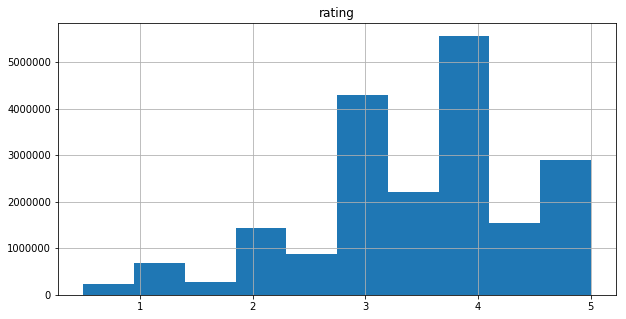

In [27]:
%matplotlib inline

ratings.hist(column='rating',figsize=(10,5))

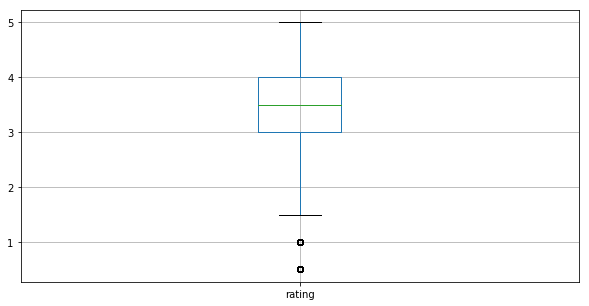

In [28]:
ratings.boxplot(column='rating', figsize=(10,5))

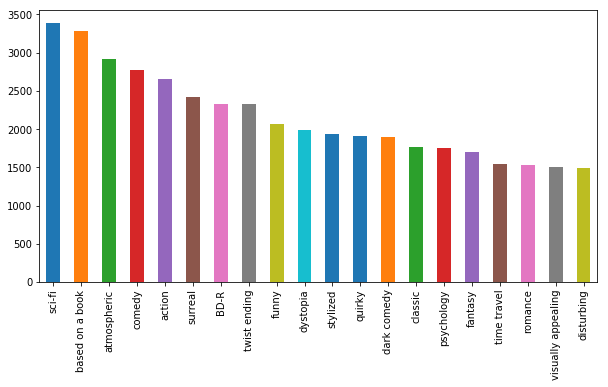

In [29]:
# there are tons of tag
tags_counts = tags['tag'].value_counts()
tags_counts[:20].plot(kind='bar', figsize=(10,5))

## ● 動作和戰爭片的關聯性

In [30]:
movies['year'] = movies['title'].str.extract('.*\((.*)\).*', expand=True)
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [31]:
# 每部電影的平均分數
avg_ratings = ratings.groupby('movieId', as_index=False).mean()
del avg_ratings['userId']
avg_ratings.head()

,movieId,rating
0,1,3.921240
1,2,3.211977
2,3,3.151040
3,4,2.861393
4,5,3.064592


In [32]:
movies = movies.merge(avg_ratings, on='movieId', how='inner')
movies.head()

,movieId,title,genres,year,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,3.921240
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3.211977
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,3.151040
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,2.861393
4,5,Father of the Bride Part II (1995),Comedy,1995,3.064592


In [33]:
act_genres = 'Action'
war_genres = 'War'

is_act  = movies['genres'].str.contains(act_genres)
not_act = ~movies['genres'].str.contains(act_genres)
is_war  = movies['genres'].str.contains(war_genres)
not_war = ~movies['genres'].str.contains(war_genres)

both     = movies[is_act & is_war]
only_act = movies[is_act & not_war]
only_war = movies[not_act & is_war]

In [34]:
both.head()

,movieId,title,genres,year,rating
108,110,Braveheart (1995),Action|Drama|War,1995,4.042534
149,151,Rob Roy (1995),Action|Drama|Romance|War,1995,3.539038
461,465,Heaven & Earth (1993),Action|Drama|War,1993,3.267635
462,466,Hot Shots! Part Deux (1993),Action|Comedy|War,1993,2.914503
639,647,Courage Under Fire (1996),Action|Crime|Drama|War,1996,3.549411


In [35]:
only_act.head()

,movieId,title,genres,year,rating
5,6,Heat (1995),Action|Crime|Thriller,1995,3.834930
8,9,Sudden Death (1995),Action,1995,3.004924
9,10,GoldenEye (1995),Action|Adventure|Thriller,1995,3.430029
14,15,Cutthroat Island (1995),Action|Adventure|Romance,1995,2.721993
19,20,Money Train (1995),Action|Comedy|Crime|Drama|Thriller,1995,2.880754


In [36]:
only_war.head()

,movieId,title,genres,year,rating
40,41,Richard III (1995),Drama|War,1995,3.852101
72,73,"Misérables, Les (1995)",Drama|War,1995,3.806768
153,155,Beyond Rangoon (1995),Adventure|Drama|War,1995,3.407915
155,157,Canadian Bacon (1995),Comedy|War,1995,2.784669
159,161,Crimson Tide (1995),Drama|Thriller|War,1995,3.744202


In [37]:
print("The dataset which includes both Action and War genres has {0} rows.".format(len(both)))
print("The dataset which includes just Action genre has {0} rows.".format(len(only_act)))
print("The dataset which includes just War genre has {0} rows.".format(len(only_war)))

The dataset which includes both Action and War genres has 295 rows.
The dataset which includes just Action genre has 3171 rows.
The dataset which includes just War genre has 878 rows.


In [38]:
act_rating  = only_act[['rating','year']].groupby(['year'],as_index=False).mean()
war_rating  = only_war[['rating','year']].groupby(['year'],as_index=False).mean()
both_rating = act_rating.merge(war_rating, on='year', how='inner')
both_rating.head()

,year,rating_x,rating_y
0,1914,2.666667,3.305556
1,1915,3.433333,3.228650
2,1919,2.817073,3.875000
3,1921,3.000000,3.166667
4,1922,3.750000,3.000000


In [39]:
both_rating['rating_x'].corr(both_rating['rating_y'])

0.00679183922506637

結論：   

兩者的皮爾森係數很低，表示動作片和戰爭片兩種電影關係很小，太好了，下回可以拿這個結果勇敢拒絕邀約。

------------------------------------------------------

# ● 電影類型影響評價

## Data Cleaning

In [40]:
movie_genres_lst = ['Action','Adventure','Animation','Children','Comedy',
                    'Crime','Documentary','Drama','Fantasy','Film-Noir',
                    'Horror','Musical','Mystery','Romance','Sci-Fi',
                    'Thriller','War','Western']
for i in movie_genres_lst:
    movies[i] = movies['genres'].str.contains(i)

In [41]:
movies.shape

(26744, 23)

In [331]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [43]:
for i in movies.columns:
    if movies[i].dtype==bool:
        movies[i]=movies[i].astype('int')

In [44]:
movies.head()

,movieId,title,genres,year,rating,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,3.921240,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3.211977,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,3.151040,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,2.861393,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,3.064592,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


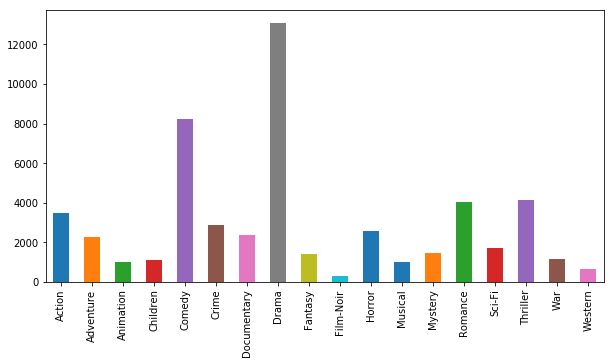

In [45]:
genres_counts=[]
for i in movie_genres_lst:
    genres_counts.append(movies[i].value_counts()[1])

pd.Series(genres_counts, index=movie_genres_lst).plot(kind='bar', figsize=(10,5))

## Using LinearRegression

In [46]:
X = movies[['Action','Adventure','Animation','Children','Comedy',
            'Crime','Documentary','Drama','Fantasy','Film-Noir',
            'Horror','Musical','Mystery','Romance','Sci-Fi',
            'Thriller','War','Western']]
X.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
y = movies['rating']
y.head()

0    3.921240
1    3.211977
2    3.151040
3    2.861393
4    3.064592
Name: rating, dtype: float64

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [49]:
X_train.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
15065,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
6790,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4934,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
20646,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11456,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [50]:
X_test.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
2393,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
943,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
12250,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5226,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
22441,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
y_train.head()

15065    3.437500
6790     3.214744
4934     2.375000
20646    3.000000
11456    3.653061
Name: rating, dtype: float64

In [52]:
y_test.head()

2393     3.096299
943      3.509146
12250    3.181334
5226     2.079957
22441    4.000000
Name: rating, dtype: float64

In [53]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [54]:
from sklearn.metrics import accuracy_score
regr_y_predicted = regr.predict(X_test)

In [55]:
from sklearn.preprocessing import StandardScaler

ss_X = StandardScaler()
ss_y = StandardScaler()

X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)
y_train = ss_y.fit_transform(y_train.reshape(-1, 1))
y_test = ss_y.transform(y_test.reshape(-1, 1))

C:\Users\Yoh\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
C:\Users\Yoh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


In [56]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
mean_absolute_error(y_test, regr_y_predicted)

print('R-squared value of LinearRegression:',regr.score(X_test,y_test))
print('The mean squared error of LinearRegression:',mean_squared_error(ss_y.inverse_transform(y_test),
                                                                            ss_y.inverse_transform(regr_y_predicted)))
print('The mean absolute error of LinearRegression:',mean_absolute_error(ss_y.inverse_transform(y_test),
                                                                              ss_y.inverse_transform(regr_y_predicted)))

R-squared value of LinearRegression: -8.967989310241814
The mean squared error of LinearRegression: 4.738570908706021
The mean absolute error of LinearRegression: 2.0842202057689656


## Using Integrated Models

In [57]:
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
rfr_y_predict=rfr.predict(X_test)

etr = ExtraTreesRegressor()
etr.fit(X_train,y_train)
etr_y_predict=etr.predict(X_test)

gbr = GradientBoostingRegressor()
gbr.fit(X_train,y_train)
gbr_y_predict=gbr.predict(X_test)

C:\Users\Yoh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
C:\Users\Yoh\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\Yoh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [58]:
print('R-squared value of RandomForestRegressor:',rfr.score(X_test,y_test))
print('The mean squared error of RandomForestRegressor:',mean_squared_error(ss_y.inverse_transform(y_test),
                                                                            ss_y.inverse_transform(rfr_y_predict)))
print('The mean absolute error of RandomForestRegressor:',mean_absolute_error(ss_y.inverse_transform(y_test),
                                                                              ss_y.inverse_transform(rfr_y_predict)))
print()
print('R-squared value of ExtraTreesRegressor:',etr.score(X_test,y_test))
print('The mean squared error of ExtraTreesRegressor:',mean_squared_error(ss_y.inverse_transform(y_test),
                                                                          ss_y.inverse_transform(etr_y_predict)))
print('The mean absolute error of ExtraTreesRegressor:',mean_absolute_error(ss_y.inverse_transform(y_test),
                                                                            ss_y.inverse_transform(etr_y_predict)))
print()
print('R-squared value of GradientBoostingRegressor:',gbr.score(X_test,y_test))
print('The mean squared error of GradientBoostingRegressor:',mean_squared_error(ss_y.inverse_transform(y_test),
                                                                                ss_y.inverse_transform(gbr_y_predict)))
print('The mean absolute error of GradientBoostingRegressor:',mean_absolute_error(ss_y.inverse_transform(y_test),
                                                                                  ss_y.inverse_transform(gbr_y_predict)))

R-squared value of RandomForestRegressor: 0.10000365977654702
The mean squared error of RandomForestRegressor: 0.3938780864944065
The mean absolute error of RandomForestRegressor: 0.467671136116887

R-squared value of ExtraTreesRegressor: 0.08993667897282731
The mean squared error of ExtraTreesRegressor: 0.39828384122754307
The mean absolute error of ExtraTreesRegressor: 0.4699818480481235

R-squared value of GradientBoostingRegressor: 0.11981007605847116
The mean squared error of GradientBoostingRegressor: 0.3852099253066632
The mean absolute error of GradientBoostingRegressor: 0.4618750360266997


結論：

先試試線性回歸，因為它可以很快地給出結果。   
結果非常不理想，R Squared甚至為負數，  
瞎猜的機率或許還比較高，這表示數據間沒什麼線性關係。

再試試其他複合式模型(快速套用其他模型是Python的強項)，   
R Squared提升了，但是依然很低(0.1)。  
看來電影公司可以大膽拍攝不同類型的電影，不用擔心小不小眾的問題了。

------------------------------------------------------

## ● 電影評價與票房

In [77]:
movies = pd.read_csv('ml-20m/movies.csv', sep=',')
ratings = pd.read_csv('ml-20m/ratings.csv', sep=',')
links = pd.read_csv('ml-20m/links.csv', sep=',')

In [130]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [131]:
movies_links = movies.merge(links, on='movieId', how='inner')
movies_links.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [132]:
movies_links['imdbId'] = movies_links['imdbId'].astype(str)
movies_links.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [133]:
movies_links['link'] = ['http://www.imdb.com/title/tt0'+i for i in movies_links['imdbId']]
del movies_links['genres']
del movies_links['imdbId']
del movies_links['tmdbId']

movies_links.head()

,movieId,title,link
0,1,Toy Story (1995),http://www.imdb.com/title/tt0114709
1,2,Jumanji (1995),http://www.imdb.com/title/tt0113497
2,3,Grumpier Old Men (1995),http://www.imdb.com/title/tt0113228
3,4,Waiting to Exhale (1995),http://www.imdb.com/title/tt0114885
4,5,Father of the Bride Part II (1995),http://www.imdb.com/title/tt0113041


In [135]:
movies_links = movies_links.sample(frac=1).head(2000)
movies_links.shape

(2000, 3)

In [136]:
import requests
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import seaborn as sns
import re
import time
import os

headers = {'User-Agent':
           'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36'}

imdb_rating_lst = []
gross_usa_lst = []

def imdb_movie_info(url):   
    res =  requests.get(url, headers = headers)
    soup = BeautifulSoup(res.text, 'lxml')
    imdb_rating = soup.select_one('strong span')
    gross_usa = re.findall('Gross USA:</h4>.*',str(soup.select('div.article div.txt-block')))    
    return imdb_rating, gross_usa

for url in movies_links['link']:
    imdb_rating, gross_usa = imdb_movie_info(url)  
    try:
        imdb_rating_lst.append(imdb_rating.text )
    except:
        imdb_rating_lst.append('')
    try:
        gross_usa_lst.append(gross_usa[0])
    except:
        gross_usa_lst.append('')
    time.sleep(0.5)

In [137]:
len(imdb_rating_lst)

2000

In [138]:
len(gross_usa_lst)

2000

In [178]:
gross_usa_lst2=[]
for i in gross_usa_lst:
    try:
        gross_usa_lst2.append(int(re.findall('[$].*',i)[0].lstrip('$').replace(',','').split('<')[0]))
    except:
        gross_usa_lst2.append('')

In [179]:
len(gross_usa_lst2)

2000

In [180]:
gross_usa_lst2[:10]

[9055010, '', '', '', 4059680, 28131, '', 49200230, '', '']

In [182]:
imdb_movie_info_dict = {'imdb_rating':imdb_rating_lst,
                        'gross_usa':gross_usa_lst2}
imdb_movie_info_df = pd.DataFrame(imdb_movie_info_dict)

In [188]:
imdb_movie_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
gross_usa      2000 non-null object
imdb_rating    2000 non-null object
dtypes: object(2)
memory usage: 31.3+ KB


In [353]:
os.getcwd()
#imdb_movie_info_df.to_csv('imdb_movie_info') 爬一次資料要花很多時間，趕緊把結果匯成csv存起來

'C:\\Users\\Yoh'

In [213]:
movies_links.head()

,movieId,title,link
8186,8869,First Daughter (2004),http://www.imdb.com/title/tt0361620
7521,7846,Tremors 3: Back to Perfection (2001),http://www.imdb.com/title/tt0259685
13643,68128,"Mindscape of Alan Moore, The (2003)",http://www.imdb.com/title/tt0410321
20888,102070,Grabbers (2012),http://www.imdb.com/title/tt01525366
5518,5617,Secretary (2002),http://www.imdb.com/title/tt0274812


In [212]:
imdb_movie_info_df.head()

,gross_usa,imdb_rating
0,9055010,5.0
1,,5.4
2,,7.6
3,,6.3
4,4059680,7.0


In [413]:
#movies_links.shape
imdb_movie_info_df.shape

(2000, 2)

In [414]:
len(imdb_rating_lst)

2000

In [415]:
movies_links['imdb_rating'] = imdb_rating_lst
movies_links['gross_usa'] = gross_usa_lst2
movies_links.shape

(2000, 5)

In [416]:
movies_links.head()

,movieId,title,link,imdb_rating,gross_usa
8186,8869,First Daughter (2004),http://www.imdb.com/title/tt0361620,5.0,9055010
7521,7846,Tremors 3: Back to Perfection (2001),http://www.imdb.com/title/tt0259685,5.4,
13643,68128,"Mindscape of Alan Moore, The (2003)",http://www.imdb.com/title/tt0410321,7.6,
20888,102070,Grabbers (2012),http://www.imdb.com/title/tt01525366,6.3,
5518,5617,Secretary (2002),http://www.imdb.com/title/tt0274812,7.0,4059680


In [417]:
movies_sum_info = movies_links.replace('', np.nan).dropna()
movies_sum_info.isnull().any()

movieId        False
title          False
link           False
imdb_rating    False
gross_usa      False
dtype: bool

In [418]:
print('Highest box office: ',int(movies_sum_info['gross_usa'].max()),'USD')
print('Lowest box office: ',int(movies_sum_info['gross_usa'].min()),'USD')

Highest box office:  424668047 USD
Lowest box office:  498 USD


In [419]:
movies_sum_info['gross_usa'].describe()

count    6.010000e+02
mean     2.072771e+07
std      4.421901e+07
min      4.980000e+02
25%      1.092480e+05
50%      1.602466e+06
75%      2.147105e+07
max      4.246680e+08
Name: gross_usa, dtype: float64

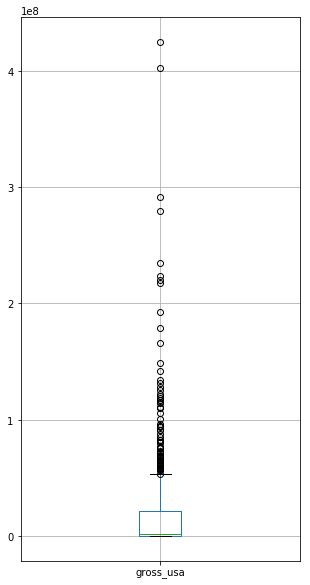

In [428]:
# 觀察票房分布
pd.DataFrame(movies_sum_info['gross_usa']).boxplot(column='gross_usa', figsize=(5,10))

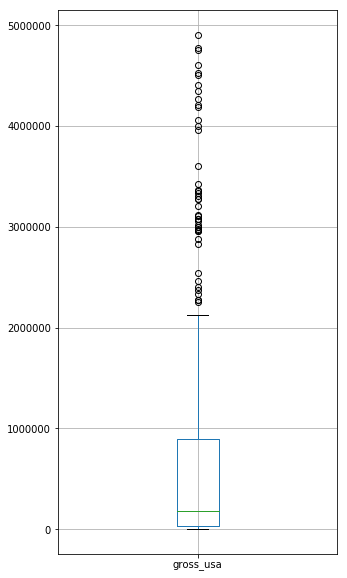

In [429]:
# 去掉極端值，抓票房5000000以內的電影
movies_sum_info_con = movies_sum_info[movies_sum_info['gross_usa']<5000000]
pd.DataFrame(movies_sum_info_con['gross_usa']).boxplot(column='gross_usa', figsize=(5,10))

Text(0,0.5,'IMDB Rating')

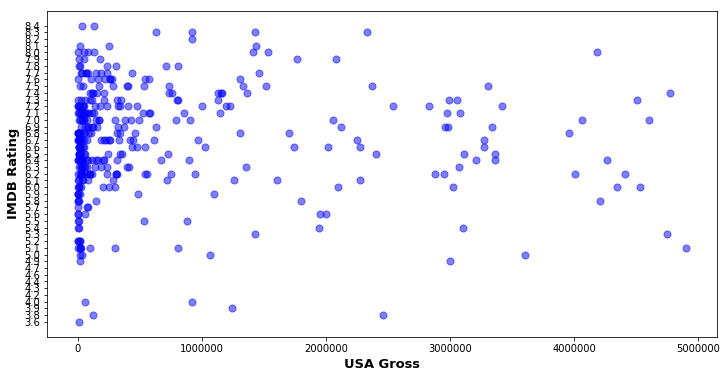

In [422]:
X = movies_sum_info_con['gross_usa'].values
Y = movies_sum_info_con['imdb_rating'].values

plt.figure(figsize=(12,6))
plt.scatter(X, Y, c='blue', s=50, alpha=0.5)
plt.xlabel('USA Gross',fontsize=13,fontweight='bold')
plt.ylabel('IMDB Rating',fontsize=13,fontweight='bold')

#plt.show()

兩種特徵似乎沒有明顯的正相關，但是大部分電影似乎仍落在一百萬內的區間。

In [426]:
movies_sum_info_con = movies_sum_info[movies_sum_info['gross_usa']<1000000]

Text(0,0.5,'IMDB Rating')

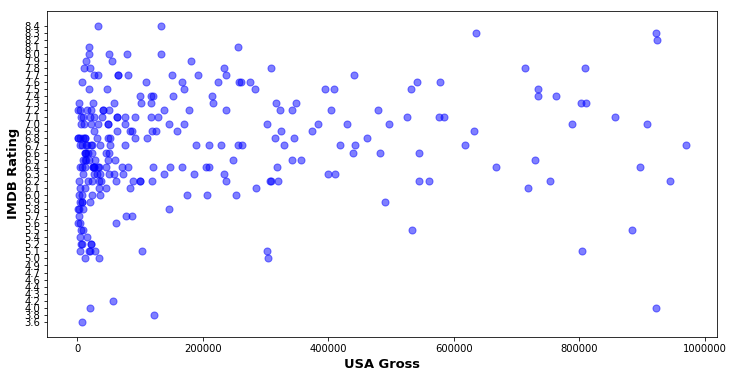

In [427]:
X = movies_sum_info_con['gross_usa'].values
Y = movies_sum_info_con['imdb_rating'].values

plt.figure(figsize=(12,6))
plt.scatter(X, Y, c='blue', s=50, alpha=0.5)
plt.xlabel('USA Gross',fontsize=13,fontweight='bold')
plt.ylabel('IMDB Rating',fontsize=13,fontweight='bold')

#plt.show()

結論：  
即使在低成本的區間，兩種特徵無明顯的正相關，看來電影評價與票房不一定成正比。